Charles Deng 12334214

Sosuke Kohda 12160736

Owen Howell 12104004

Holly Cao 12333838

### This notebook performs feature selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter

import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
import pickle
warnings.filterwarnings("ignore")

### Load data

In [2]:
raw_data = pd.read_pickle(r'data_new.pickle')
data = raw_data.copy()
data.fillna(0.0,inplace=True)
data.iloc[:,1:] = data.iloc[:,1:].apply(pd.to_numeric)

In [3]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.01:
        return -1
    else:
    
        return 0

In [4]:
data['rel_performance'] = data['ret'].apply(f)
data.reset_index(inplace=True,)
data.set_index('statistic_date',inplace=True)

In [5]:
df_1 = data.loc['2017-01-01':'2020-01-01']
df_valid = data.loc['2020-01-01':'2020-06-01']
df_test = data.loc['2020-06-01':'2022-07-01']

In [6]:
train_1 = df_1.reset_index().drop(['index','fund_id','ret','rel_performance','ret_2m','ret_3m','statistic_date'],axis=1)
valid = df_valid.reset_index().drop(['index','fund_id','ret','rel_performance','ret_2m','ret_3m','statistic_date'],axis=1)
test = df_test.reset_index().drop(['index','fund_id','ret','rel_performance','ret_2m','ret_3m','statistic_date'],axis=1)

In [7]:
train_1_stock_returns = df_1['ret']
valid_stock_returns = df_valid['ret']
test_stock_returns = df_test['ret']

y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_valid = y_valid.values
y_test = y_test.values

### Optuna objective function

In [8]:
def profit_importance(m,df,rets):
    """ Compute profit importance as mean profit of 100 trials on shuffled feature.
    :param m: classifer
    :param df: dataframe containing features
    :param rets: returns
    return: arary of profit scores for the input features
    """
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(100):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = m.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

In [9]:
def randomforest_profit_importance(m, df,rets):
    """ Compute profit importance as mean profit of 100 trials on shuffled feature.
    :param m: classifer
    :param df: dataframe containing features
    :param rets: returns
    return: dataframe of profit scores for the input features
    """
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [20]:
def randomforest_feat_importances(m, df):
    """ Return importance of the features from randomforest library
    :param m: classifer
    :param df: dataframe containing features
    return: dataframe of profit scores for the input features
    """
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [21]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):
    """ Objective function to perform Bayesian search using optuna
    :param train: training data
    :param labels: training labels
    :param val: validation data
    :param val_labels: validation data labels
    :param val_rets: validation period returns (before being transformed into labels)
    return: total profit on the validation set
    """
    rf_n_estimators = trial.suggest_int('n_estimators', 10,40,step=5)
    rf_max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',800,2400,step=800)
    rf_max_depth = trial.suggest_int('max_depth',4,15)
    
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    max_features=rf_max_features)
    rf_clf.fit(train,labels)
    preds = rf_clf.predict(val)
    profit = (preds * val_rets).sum()
 
    return profit

In [12]:
study = optuna.create_study(direction="maximize")

In [13]:
from functools import partial

### Get Best Hyperparameters

In [17]:
%%time
study.optimize(partial(objective,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=100,n_jobs=-1)

CPU times: user 2min 42s, sys: 927 ms, total: 2min 43s
Wall time: 27.4 s


In [15]:
study.best_params

{'n_estimators': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 800,
 'max_depth': 4}

In [18]:
start_dates = [pd.to_datetime('2017-01-01') + pd.DateOffset(months = 1 * i) for i in range(54)]
end_dates = [d + pd.DateOffset(months = 6) for d in start_dates]

training_frames = [data.loc[d.strftime("%Y-%m-%d"):(d+pd.DateOffset(months = 6)).strftime("%Y-%m-%d")] for d in start_dates]
validation_frames = [data.loc[d.strftime("%Y-%m-%d"):(d+pd.DateOffset(months = 3)).strftime("%Y-%m-%d")] for d in end_dates]
test_frames =  [data.loc[(d+pd.DateOffset(months = 3)).strftime("%Y-%m-%d"):(d+pd.DateOffset(months = 4)).strftime("%Y-%m-%d")] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['index','fund_id','ret','rel_performance','ret_2m','ret_3m','statistic_date'],axis=1) for d in training_frames]

validation_data = [d.reset_index().drop(['index','fund_id','ret','rel_performance','ret_2m','ret_3m','statistic_date'],axis=1) for d in validation_frames]

test_data = [d.reset_index().drop(['index','fund_id','ret','rel_performance','ret_2m','ret_3m','statistic_date'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in validation_frames]

## Compute optimal features at each Month

In [19]:
optimal_features = []
classifiers = []

for i in range(len(training_data)):
    print('Month ' + str(i))
    #     study = optuna.create_study(direction="maximize")
    #     study.optimize(partial(objective,train=training_data[i],
    #                            labels=training_labels[i],
    #                            val=validation_data[i],
    #                            val_labels=validation_labels[i],
    #                            val_rets = validation_frames[i]['ret']),
    #                            n_trials=100,n_jobs=-1)

    #     params_1 = study.best_params
    #     print(params_1)
    params = study.best_params
    
    rf_clf = RandomForestClassifier(**params)

    classifiers.append(rf_clf)
    
    rf_clf.fit(training_data[i],training_labels[i])
    fi = randomforest_feat_importances(rf_clf,training_data[i])
    features = fi[fi['feat_imp'] > 0.000]
    
    train = training_data[i][features['cols'].values].copy()
    validation = validation_data[i][features['cols'].values].copy()
    
    
    profits = []
    feat=[]
    
    rf_clf.fit(train,training_labels[i])
    
    while len(train.columns)>1:
        
        pi = randomforest_profit_importance(rf_clf,validation,validation_frames[i]['ret'])
        col_to_drop = pi.iloc[-1]['cols']
        train.drop(col_to_drop,axis=1,inplace=True)
        validation.drop(col_to_drop,axis=1,inplace=True)
        
        rf_clf.fit(train,training_labels[i])
        pred_valid = rf_clf.predict(validation)
        profits.append((pred_valid * validation_frames[i]['ret']).sum())
        feat.append(train.columns)
        
    n = np.argmax(profits)

    max_profits = profits[n]

    optim_feats = feat[n]
    
    print(optim_feats)
    print(max_profits)

    optimal_features.append(optim_feats)

Month 0
Index(['year_n_earning_days', 'm3_con_fall_days', 'm3_excess_a',
       'y1_return_Msqr', 'year_kurtosis', 'y1_max_return', 'm6_return',
       'm3_max_return', 'year_return', 'y1_return'],
      dtype='object')
42.05089211394887
Month 1
Index(['year_persistence', 'total_assets', 'year_p_earning_days',
       'year_max_return', 'org_compensation_payable', 'stock_income',
       'transaction_monetary_assets', 'trustee_payable', 'paid_up_capital',
       'y1_ERCVaR', 'y1_return_a', 'm6_return_a', 'total_VaR', 'y1_sor_a'],
      dtype='object')
10.926265391410984
Month 2
Index(['total_liabilities_and_owners_equity', 'bank_deposit', 'y1_downsidecap',
       'refundable_deposits', 'owner_equity', 'year_stdev',
       'year_max_drawdown', 'm6_downsidecap', 'year_con_rise_days',
       'org_compensation_payable'],
      dtype='object')
5.228057872585589
Month 3
Index(['year_max_return', 'm6_beta', 'm6_timing_hm', 'm6_average_drawdown',
       'm6_max_return', 'm6_sharpe_a', 'm6_pain_i

Index(['m3_ERVaR', 'm3_sharpe_a'], dtype='object')
24.967713604741313
Month 43
Index(['m3_ERVaR'], dtype='object')
58.24350333740057
Month 44
Index(['year_skewness', 'm6_info_a', 'year_p_earning_days', 'quarter_return',
       'm6_tr_a', 'year_max_drawdown', 'year_n_earning_days', 'm6_burke_a',
       'm6_ddr3_a', 'm6_CVaR', 'm3_return', 'm6_s_security'],
      dtype='object')
74.67034475102575
Month 45
Index(['total_tracking_error_a', 'm6_info_a', 'total_corr_spearman', 'm6_VaR',
       'm3_sharpe_a', 'm6_adjusted_jensen_a', 'm3_sor_a', 'm3_jensen_a',
       'quarter_return', 'm6_ddr3_a', 'm6_assess_ratio', 'total_odds',
       'm3_n_earning_days'],
      dtype='object')
34.151587212256345
Month 46
Index(['m3_return', 'year_max_return', 'y1_ERVaR', 'm3_jensen_a'], dtype='object')
10.603307679411467
Month 47
Index(['m3_max_drawdown', 'm3_return_a', 'm3_info_a', 'year_odds'], dtype='object')
2.7449859027604546
Month 48
Index(['m3_con_rise_days', 'y1_timing_hm'], dtype='object')
37.94336

### Trading each month using optimized feature with equal weight ( for preliminary assessment) 

In [67]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):

        classifiers[i-1].fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = classifiers[i-1].predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['ret']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

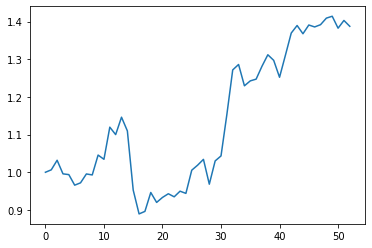

In [68]:
plt.plot(x[1:]);

In [69]:
opt = [np.array(optimal_features[i]) for i in range(len(optimal_features))]
ordered_feat = Counter(np.concatenate(opt,axis=0)).most_common()
most_common_feat = [x[0] for x in ordered_feat if x[1]>5]

In [70]:
most_common_feat

['m3_min_return',
 'm3_return_a',
 'quarter_return',
 'm3_dd_a',
 'm3_max_return',
 'm3_ERVaR',
 'm3_tr_a',
 'm6_stdev',
 'm3_stdev',
 'm3_VaR',
 'm3_sharpe_a',
 'year_max_drawdown',
 'year_min_return',
 'year_p_earning_days',
 'year_return',
 'm3_return',
 'm3_max_drawdown',
 'year_kurtosis',
 'm6_min_return',
 'total_corr_spearman',
 'year_n_earning_days',
 'm6_pain_index',
 'year_con_rise_days',
 'm3_corr',
 'y1_sterling_a',
 'm6_assess_ratio',
 'm3_sor_a',
 'year_skewness',
 'm3_unsys_risk',
 'm3_con_fall_days']

In [76]:
with open('rf_optimal_features_monthly.pickle','wb') as f:
    pickle.dump(optimal_features, f)